In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

import utils2.testing_gen as gen
import utils2.loading as load
import utils2.nn_gen as nn_gen
from utils2.tools import array2List

from NNSimulator import genSim, getSimulationData


from norm import normalizeGraph

from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader


yessss sir
>>>>>>>>>>>> LOADOING THE V2 OF FEATURES
fndjngkjdfs --NN-sim
update


In [2]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [3]:
import stats.stats_re as stats
import yaml

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

PATH = ['/home/jpierre/v2/results_end/files/roll/gat']
MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = 'gat'

In [5]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [6]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(MODEL, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [7]:
class id():
    def __init__(self):
        self.nbLayer = None
        self.dropout = None
        self.layerNorm = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            nb_layer_match = re.search(r'nbLyaer-(\d+)', path)
            dropout_match = re.search(r'dropout-(\d+)', path)
            layer_norm_match = re.search(r'layerNorm-(\d+)', path)

            self.nbLayer = int(nb_layer_match.group(1))
            self.dropout = int(dropout_match.group(1))
            self.layerNorm = int(layer_norm_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_nbLayer-{self.nbLayer}_dropout{self.dropout}_layerNorm{self.layerNorm}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    res.extend(get_path_models(path))

In [8]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/gat_best.pt >>> {'nbLayer': 1, 'dropout': 0, 'layerNorm': 1, 'path': '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/gat_best.pt', 'loss': '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'cfg': '/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-1_dropout-0_layerNorm-1/cfg.yml'}
/home/jpierre/v2/results_end/files/roll/gat/mt_gat_noisy_nbLyaer-2_dropout-0_layerNorm-1/model_trained/gat_best.pt >>> {'nbLayer': 2, 'dropout': 0, 'layerNorm': 1, 'path': '/home/

# =====================

In [9]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_layers = []
normal_layers_val = []

noisy_models_layers = []
noisy_layers_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            nbLayer = r.nbLayer
            normal_layers_val.append(nbLayer)


            normal_models_layers.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            nbLayer = r.nbLayer
            noisy_layers_val.append(nbLayer)


            noisy_models_layers.append(r)


# ===================

In [10]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 400


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


data_gt_1  = gen.get_mult_data(params1, NB_SIM)
graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
data_gt_list_1 = array2List(data_gt_1)


#data_gt_2 = gen.get_mult_data(params2, NB_SIM)
#graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
#data_gt_list_2 = array2List(data_gt_2)

0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:06<00:00, 60.38it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:06<00:00, 65.19it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:06<00:00, 64.40it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:09<00:00, 43.29it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:10<00:00, 39.49it/s]


In [11]:
start = 250
length = 100

stop = start+length

In [12]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_normal = stats.MSD_stat(data_gt_1[:, start:stop])
RDF_base_normal  = stats.apply_rdf(data_gt_1[:, start:stop])
SCAT_base_normal = stats.applySelfScattering(data_gt_1[:, start:stop])
DISTR_base_normal = stats.apply_hist(data_gt_1, a, b)
SUM_base_normal = stats.sumSpeeds(data_gt_1[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:02<00:00, 39.54it/s]


In [13]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
#p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:03,  3.32s/it]


In [14]:
from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader




In [15]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [16]:
MSD_list_normal = []
RDF_list_normal = []
SCAT_list_normal = []
DISTR_list_normal = []
SUM_list_normal = []
MSE_rollout = []

device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []


a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)






for i in tqdm(range(len(normal_models_layers))):

    ## load model
    cfg = normal_models_layers[i].cfg
    std_path = normal_models_layers[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_1, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_1.copy()[:, start:stop])



    MSD_list_normal.append(msd)
    RDF_list_normal.append(rdf)
    SCAT_list_normal.append(scat)
    DISTR_list_normal.append(speed_distr)
    SUM_list_normal.append(sum_speed)
    
    ##############
    
    
    cfg_eval = EvaluationCfg()
    cfg_eval.norm_angleError = Param_eval(path = os.path.join(os.getcwd(), 'angle.png'))
    #cfg_eval.L1_vect = Param_eval(wandbName = 'Std message')
    cfg_eval.degree_error = Param_eval(path = os.path.join(os.getcwd(), 'degree.png'))


    # loader ...

    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 100.04it/s]

100%|██████████| 99/99 [00:00<00:00, 112.25it/s]

100%|██████████| 99/99 [00:00<00:00, 112.73it/s]

100%|██████████| 99/99 [00:00<00:00, 148.17it/s]

100%|██████████| 99/99 [00:00<00:00, 131.70it/s]

100%|██████████| 100/100 [00:02<00:00, 48.81it/s][A

100%|██████████| 100/100 [00:02<00:00, 46.72it/s][A

100%|██████████| 100/100 [00:02<00:00, 37.79it/s][A

100%|██████████| 100/100 [00:02<00:00, 37.71it/s]

100%|██████████| 100/100 [00:02<00:00, 43.08it/s][A

 18%|█▊        | 28/155 [01:00<01:51,  1.14it/s]


100%|██████████| 155/155 [02:35<00:00,  1.80it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 164.80it/s]

100%|██████████| 15/15 [00:00<00:00, 239.12it/s]

100%|██████████| 15/15 [00:00<00:00, 259.99it/s]

100%|██████████| 15/15 [00:00<00:00, 195.65it/s]

100%|██████████| 15/15 [00:00<00:00, 196.88it/s]

100%|██████████| 15/15 [00:00<00:00, 199.67it/s]

100%|██████████| 15/15 [00:00<00:00, 193.38it/s]

100%|██████████| 15/15 [00:00<00:00, 200.08it/s]

100%|██████████| 15/15 [00:00<00:00, 191.35it/s]

100%|██████████| 15/15 [00:00<00:00, 193.28it/s]

100%|██████████| 15/15 [00:00<00:00, 187.09it/s]

100%|██████████| 15/15 [00:00<00:00, 186.88it/s]

100%|██████████| 15/15 [00:00<00:00, 190.29it/s]

100%|██████████| 15/15 [00:00<00:00, 195.45it/s]

100%|██████████| 15/15 [00:00<00:00, 199.03it/s]

100%|██████████| 15/15 [00:00<00:00, 201.18it/s]

100%|██████████| 15/15 [00:00<00:00, 202.88it/s]

100%|██████████| 15/15 [00:00<00:00, 192.23it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 150.61it/s]

100%|██████████| 99/99 [00:00<00:00, 152.21it/s]

100%|██████████| 99/99 [00:00<00:00, 148.20it/s]

100%|██████████| 99/99 [00:00<00:00, 155.77it/s]

100%|██████████| 99/99 [00:00<00:00, 162.57it/s]

100%|██████████| 100/100 [00:01<00:00, 62.84it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.28it/s][A

100%|██████████| 100/100 [00:01<00:00, 69.52it/s][A

100%|██████████| 100/100 [00:01<00:00, 69.92it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.33it/s][A

 35%|███▍      | 54/155 [00:33<01:01,  1.63it/s]


100%|██████████| 155/155 [01:45<00:00,  1.11it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 157.81it/s]

100%|██████████| 15/15 [00:00<00:00, 157.17it/s]

100%|██████████| 15/15 [00:00<00:00, 158.22it/s]

100%|██████████| 15/15 [00:00<00:00, 139.72it/s]

100%|██████████| 15/15 [00:00<00:00, 155.84it/s]

100%|██████████| 15/15 [00:00<00:00, 153.25it/s]

100%|██████████| 15/15 [00:00<00:00, 132.45it/s]

100%|██████████| 15/15 [00:00<00:00, 153.00it/s]

100%|██████████| 15/15 [00:00<00:00, 150.88it/s]

100%|██████████| 15/15 [00:00<00:00, 154.51it/s]

100%|██████████| 15/15 [00:00<00:00, 152.78it/s]

100%|██████████| 15/15 [00:00<00:00, 154.75it/s]

100%|██████████| 15/15 [00:00<00:00, 152.19it/s]

100%|██████████| 15/15 [00:00<00:00, 152.89it/s]

100%|██████████| 15/15 [00:00<00:00, 155.16it/s]

100%|██████████| 15/15 [00:00<00:00, 154.59it/s]

100%|██████████| 15/15 [00:00<00:00, 155.09it/s]

100%|██████████| 15/15 [00:00<00:00, 155.02it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 118.61it/s]

100%|██████████| 99/99 [00:00<00:00, 118.75it/s]

100%|██████████| 99/99 [00:00<00:00, 121.50it/s]

100%|██████████| 99/99 [00:00<00:00, 124.07it/s]

100%|██████████| 99/99 [00:00<00:00, 123.27it/s]

100%|██████████| 100/100 [00:01<00:00, 68.02it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.72it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.35it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.87it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.52it/s][A

 32%|███▏      | 49/155 [01:18<01:17,  1.37it/s]


100%|██████████| 155/155 [02:31<00:00,  1.97it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 156.26it/s]

100%|██████████| 15/15 [00:00<00:00, 157.16it/s]

100%|██████████| 15/15 [00:00<00:00, 155.26it/s]

100%|██████████| 15/15 [00:00<00:00, 155.54it/s]

100%|██████████| 15/15 [00:00<00:00, 156.15it/s]

100%|██████████| 15/15 [00:00<00:00, 157.48it/s]

100%|██████████| 15/15 [00:00<00:00, 157.25it/s]

100%|██████████| 15/15 [00:00<00:00, 161.03it/s]

100%|██████████| 15/15 [00:00<00:00, 153.28it/s]

100%|██████████| 15/15 [00:00<00:00, 159.54it/s]

100%|██████████| 15/15 [00:00<00:00, 130.37it/s]

100%|██████████| 15/15 [00:00<00:00, 127.37it/s]

100%|██████████| 15/15 [00:00<00:00, 127.25it/s]

100%|██████████| 15/15 [00:00<00:00, 115.03it/s]

100%|██████████| 15/15 [00:00<00:00, 126.22it/s]

100%|██████████| 15/15 [00:00<00:00, 121.76it/s]

100%|██████████| 15/15 [00:00<00:00, 130.32it/s]

100%|██████████| 15/15 [00:00<00:00, 124.04it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 99.63it/s] 

100%|██████████| 99/99 [00:01<00:00, 98.33it/s]

100%|██████████| 99/99 [00:00<00:00, 112.73it/s]

100%|██████████| 99/99 [00:01<00:00, 97.57it/s] 

100%|██████████| 99/99 [00:00<00:00, 112.51it/s]

100%|██████████| 100/100 [00:01<00:00, 66.08it/s][A

100%|██████████| 100/100 [00:01<00:00, 64.92it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.65it/s]

100%|██████████| 100/100 [00:01<00:00, 65.00it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.75it/s]

 25%|██▍       | 38/155 [00:24<01:15,  1.55it/s]


100%|██████████| 155/155 [01:39<00:00,  2.22it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 132.39it/s]

100%|██████████| 15/15 [00:00<00:00, 132.24it/s]

100%|██████████| 15/15 [00:00<00:00, 129.23it/s]

100%|██████████| 15/15 [00:00<00:00, 132.44it/s]

100%|██████████| 15/15 [00:00<00:00, 133.11it/s]

100%|██████████| 15/15 [00:00<00:00, 134.30it/s]

100%|██████████| 15/15 [00:00<00:00, 116.46it/s]

100%|██████████| 15/15 [00:00<00:00, 129.56it/s]

100%|██████████| 15/15 [00:00<00:00, 125.71it/s]

100%|██████████| 15/15 [00:00<00:00, 127.83it/s]

100%|██████████| 15/15 [00:00<00:00, 127.15it/s]

100%|██████████| 15/15 [00:00<00:00, 132.17it/s]

100%|██████████| 15/15 [00:00<00:00, 131.82it/s]

100%|██████████| 15/15 [00:00<00:00, 132.07it/s]

100%|██████████| 15/15 [00:00<00:00, 134.65it/s]

100%|██████████| 15/15 [00:00<00:00, 138.42it/s]

100%|██████████| 15/15 [00:00<00:00, 121.58it/s]

100%|██████████| 15/15 [00:00<00:00, 108.54it/s]



In [17]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.00028301257365028094, 0.00031918717452712427, 0.0017990559507410782, 0.006325441922761273]
errors std ==> [0.0010383248586140418, 0.0010232507813362393, 0.0033609670896424045, 0.004655877367764666]
angle_error ==>  [0.038366526, 0.053084902, 0.17272544, 0.34763727]
angle_std std ==> [0.038366526, 0.053084902, 0.17272544, 0.34763727]
norm_errors_list ==>  [0.00012845918536186218, 0.00021478161215782166, 0.0012322068214416504, 0.006145769730210304]
norm_errors_std_list std ==> [0.000867223311959062, 0.0008010791379068958, 0.003263426398114058, 0.00430251094490056]
sim_error_list ==>  [0.029843352101714675, 0.02796847619226408, 0.05645729913342536, 0.08267248488846887]
sim_error_std_list std ==> [0.002064437595820785, 0.0021396283023508013, 0.0031080673210671494, 0.0017925415874532748]


In [18]:
limit_scat = 99
limit_msd = 99


In [19]:
nb_layer_list = [normal_models_layers[i].nbLayer for i in range(len(normal_models_layers))]
# layer norm
print(nb_layer_list)

[1, 2, 3, 4]


In [20]:
labels_graphs = [f'nb layer {normal_models_layers[i].nbLayer} - layer norm {normal_models_layers[i].layerNorm}' for i in range(len(normal_models_layers))]
print(labels_graphs)

['nb layer 1 - layer norm 1', 'nb layer 2 - layer norm 1', 'nb layer 3 - layer norm 1', 'nb layer 4 - layer norm 1']


In [21]:
colors = ['blue','red', 'green', 'orange', 'orange','orange', 'red', 'red']
styles = ['solid', 'solid', 'solid', 'solid', 'solid', 'dotted', 'solid', 'dotted']

(5, 99)
(5, 99)
(5, 99)
(5, 99)


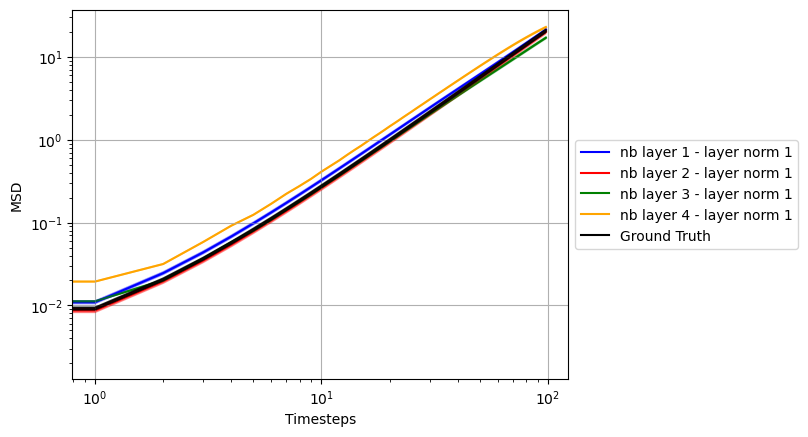

In [22]:
# plot of MSD

res_msd = []


for i in range(len(nb_layer_list)):
    print(MSD_list_normal[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_normal[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_normal[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], linestyle=styles[i], zorder = 1, label = labels_graphs[i])
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_normal[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSD-gat-normal.png', bbox_inches='tight')
plt.show()


In [23]:
msd_gt = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)

for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.21495413440899117 +- 0.1673710818667054
l1: nb layer 2 - layer norm 1 >>>> 0.1149278963580304 +- 0.12416933250756036
l1: nb layer 3 - layer norm 1 >>>> 2.193594581969798 +- 3.4026045948610313
l1: nb layer 4 - layer norm 1 >>>> 4.251465989776598 +- 3.5856128894203083


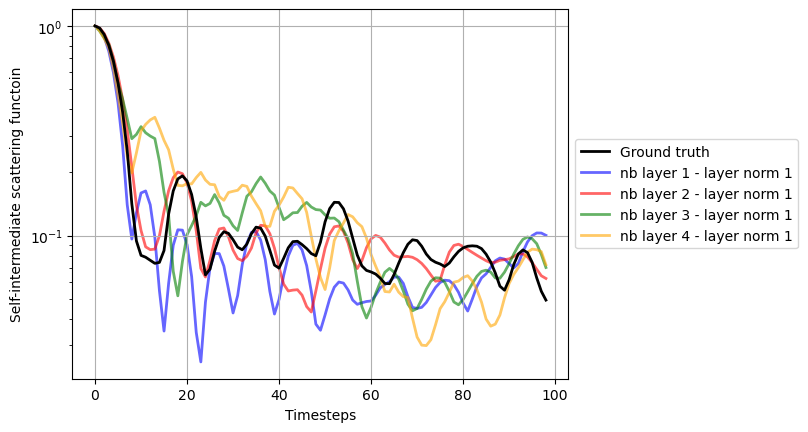

In [24]:
# plot of scat

res_scat = []

ssf_mean = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_normal[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth', zorder = 2)
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(nb_layer_list)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    res_scat.append(ssf_mean)
    ssf_std = np.std(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], linestyle=styles[i], lw=2, label = labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-gat.png', bbox_inches='tight')
plt.show()


In [25]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.002138326291107871 +- 0.002993203237611312
l1: nb layer 2 - layer norm 1 >>>> 0.0005316670384561568 +- 0.0008473306254141616
l1: nb layer 3 - layer norm 1 >>>> 0.004910802858043888 +- 0.011537405613887353
l1: nb layer 4 - layer norm 1 >>>> 0.006308822209558536 +- 0.015791743646669087


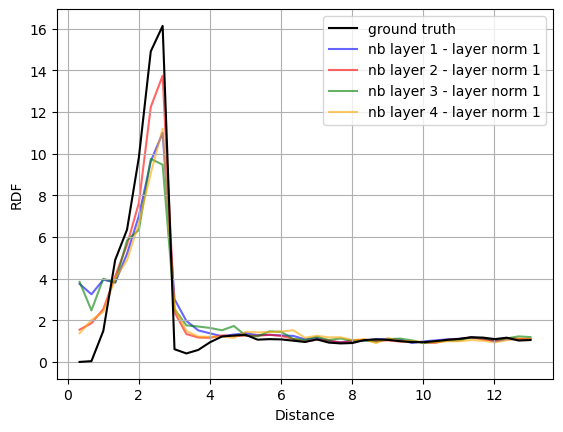

In [26]:
mean_res, std_res, r = RDF_base_normal
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4, zorder = 1)

for i in range(len(nb_layer_list)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_normal[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    res_rdf.append(mean_res)
    
    plt.plot(r, mean_res,color = colors[i], linestyle=styles[i], label =labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-gat.png', bbox_inches='tight')
plt.show()

In [27]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 5.331581411333167 +- 14.959810025962463
l1: nb layer 2 - layer norm 1 >>>> 8.115278165197306 +- 26.17355717446255
l1: nb layer 3 - layer norm 1 >>>> 4.610901334781929 +- 12.227282498880987
l1: nb layer 4 - layer norm 1 >>>> 4.941438499103439 +- 14.687016659457404


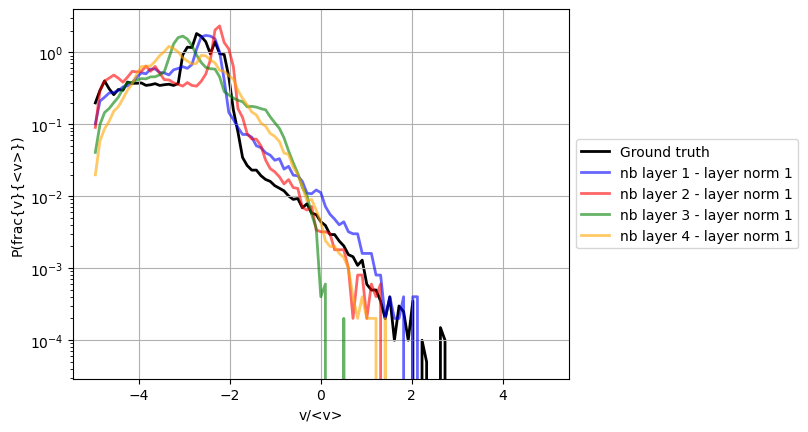

In [28]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    
    res_magn_distr.append(magn_base_mean)
    plt.semilogy(b[1:]-db/2,magn_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-gat.png', bbox_inches='tight')
plt.show()

In [29]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.026078135035469827 +- 0.08761375470310802
l1: nb layer 2 - layer norm 1 >>>> 0.0999413806403913 +- 0.34972588751324374
l1: nb layer 3 - layer norm 1 >>>> 0.07730836902043223 +- 0.2368487109098133
l1: nb layer 4 - layer norm 1 >>>> 0.06819506325298341 +- 0.18355468759918295


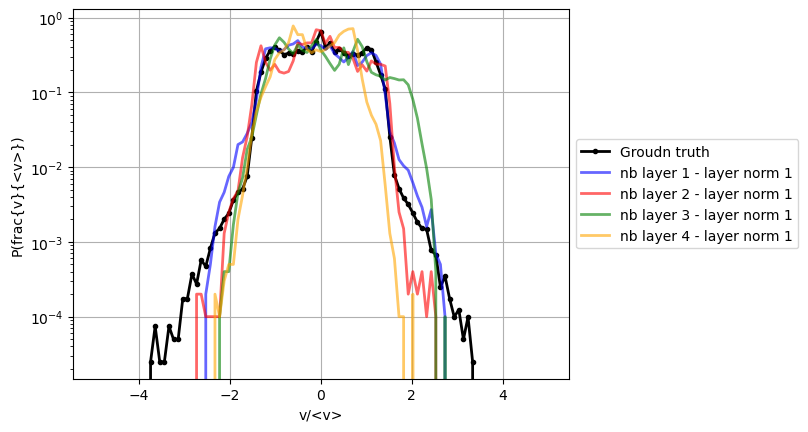

In [30]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    
    res_magn_x.append(x_base_mean)
    
    plt.semilogy(b[1:]-db/2,x_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig('speed-x-gat.png', bbox_inches='tight')
plt.show()

In [31]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.001673434871788738 +- 0.0058677979680713125
l1: nb layer 2 - layer norm 1 >>>> 0.004158006945913424 +- 0.01012482946051436
l1: nb layer 3 - layer norm 1 >>>> 0.005038477501089272 +- 0.011637741258636631
l1: nb layer 4 - layer norm 1 >>>> 0.013247003294360305 +- 0.03502141329013534


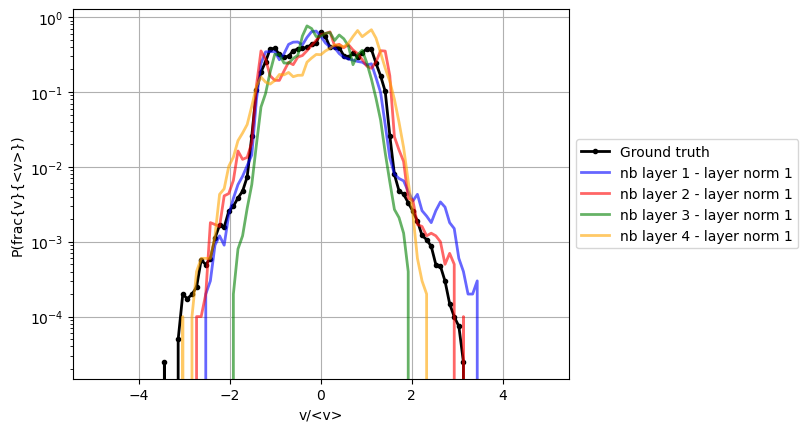

In [32]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_normal[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    
    res_magn_y.append(y_base_mean)
    
    plt.semilogy(b[1:]-db/2,y_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-gat.png', bbox_inches='tight')
plt.show()

In [33]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 0.002515128373348499 +- 0.007031337647383011
l1: nb layer 2 - layer norm 1 >>>> 0.004804748648278246 +- 0.012754183629233216
l1: nb layer 3 - layer norm 1 >>>> 0.0064825950962162735 +- 0.018284283359577245
l1: nb layer 4 - layer norm 1 >>>> 0.010831107098950415 +- 0.024174536868560907


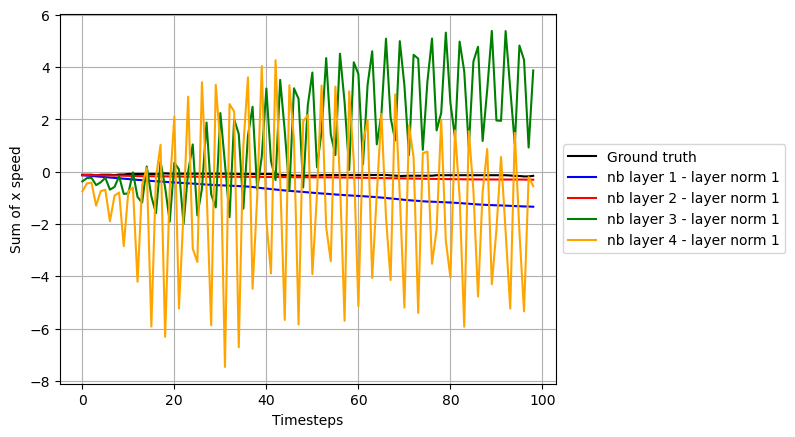

In [34]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-gat.png', bbox_inches='tight')
plt.show()

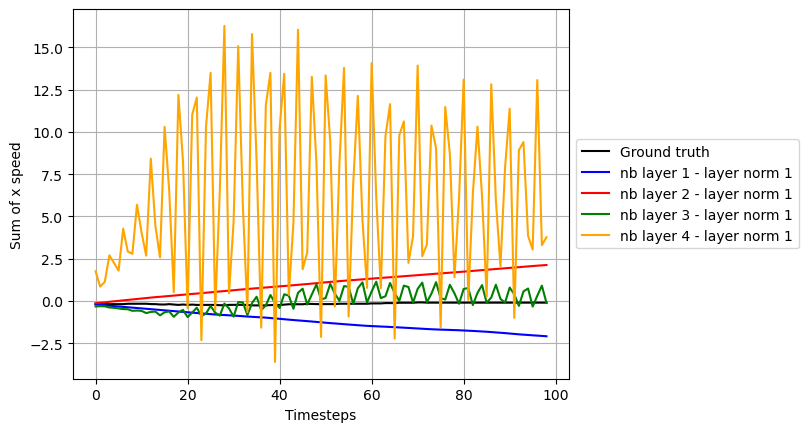

In [35]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-gat.png', bbox_inches='tight')
plt.show()

# =======================
# =======================

In [36]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 400


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


#data_gt_1  = gen.get_mult_data(params1, NB_SIM)
#graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
#data_gt_list_1 = array2List(data_gt_1)


data_gt_2 = gen.get_mult_data(params2, NB_SIM)
graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
data_gt_list_2 = array2List(data_gt_2)

1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 47.37it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 46.89it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 48.57it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 47.81it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 399/399 [00:08<00:00, 48.86it/s]


In [37]:
start = 250
length = 100

stop = start+length

In [38]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_noisy = stats.MSD_stat(data_gt_2[:, start:stop])
RDF_base_noisy  = stats.apply_rdf(data_gt_2[:, start:stop])
SCAT_base_noisy = stats.applySelfScattering(data_gt_2[:, start:stop])
DISTR_base_noisy = stats.apply_hist(data_gt_2, a, b)
SUM_base_noisy = stats.sumSpeeds(data_gt_2[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 72.79it/s]


In [39]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
#p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  5.12it/s]


In [40]:
MSD_list_noisy = []
RDF_list_noisy = []
SCAT_list_noisy = []
DISTR_list_noisy = []
SUM_list_noisy = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)


device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []






for i in tqdm(range(len(noisy_models_layers))):

    ## load model
    cfg = noisy_models_layers[i].cfg
    std_path = noisy_models_layers[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_2, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_2.copy()[:, start:stop])



    MSD_list_noisy.append(msd)
    RDF_list_noisy.append(rdf)
    SCAT_list_noisy.append(scat)
    DISTR_list_noisy.append(speed_distr)
    SUM_list_noisy.append(sum_speed)
    
    
    
    
    cfg_eval = EvaluationCfg()
    cfg_eval.norm_angleError = Param_eval(path = os.path.join(os.getcwd(), 'angle.png'))
    #cfg_eval.L1_vect = Param_eval(wandbName = 'Std message')
    cfg_eval.degree_error = Param_eval(path = os.path.join(os.getcwd(), 'degree.png'))


    # loader ...

    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))



  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 191.14it/s]

100%|██████████| 99/99 [00:00<00:00, 197.41it/s]

100%|██████████| 99/99 [00:00<00:00, 210.90it/s]

100%|██████████| 99/99 [00:00<00:00, 223.31it/s]

100%|██████████| 99/99 [00:00<00:00, 220.50it/s]

100%|██████████| 100/100 [00:01<00:00, 69.21it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.17it/s]

100%|██████████| 100/100 [00:01<00:00, 70.98it/s][A

100%|██████████| 100/100 [00:01<00:00, 69.02it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.82it/s][A

 41%|████▏     | 64/155 [00:36<01:00,  1.50it/s]


100%|██████████| 155/155 [01:25<00:00,  2.21it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 238.94it/s]

100%|██████████| 15/15 [00:00<00:00, 249.64it/s]

100%|██████████| 15/15 [00:00<00:00, 245.92it/s]

100%|██████████| 15/15 [00:00<00:00, 253.89it/s]

100%|██████████| 15/15 [00:00<00:00, 242.49it/s]

100%|██████████| 15/15 [00:00<00:00, 255.96it/s]

100%|██████████| 15/15 [00:00<00:00, 248.17it/s]

100%|██████████| 15/15 [00:00<00:00, 257.28it/s]

100%|██████████| 15/15 [00:00<00:00, 254.81it/s]

100%|██████████| 15/15 [00:00<00:00, 254.99it/s]

100%|██████████| 15/15 [00:00<00:00, 253.33it/s]

100%|██████████| 15/15 [00:00<00:00, 253.47it/s]

100%|██████████| 15/15 [00:00<00:00, 250.16it/s]

100%|██████████| 15/15 [00:00<00:00, 252.69it/s]

100%|██████████| 15/15 [00:00<00:00, 253.93it/s]

100%|██████████| 15/15 [00:00<00:00, 266.26it/s]

100%|██████████| 15/15 [00:00<00:00, 246.18it/s]

100%|██████████| 15/15 [00:00<00:00, 260.80it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 150.87it/s]

100%|██████████| 99/99 [00:00<00:00, 150.91it/s]

100%|██████████| 99/99 [00:00<00:00, 161.54it/s]

100%|██████████| 99/99 [00:00<00:00, 160.58it/s]

100%|██████████| 99/99 [00:00<00:00, 177.07it/s]

100%|██████████| 100/100 [00:01<00:00, 66.72it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.34it/s][A

100%|██████████| 100/100 [00:01<00:00, 68.49it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.21it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.67it/s][A

 35%|███▌      | 55/155 [00:30<01:02,  1.60it/s]


100%|██████████| 155/155 [01:26<00:00,  2.22it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 193.60it/s]

100%|██████████| 15/15 [00:00<00:00, 196.79it/s]

100%|██████████| 15/15 [00:00<00:00, 197.54it/s]

100%|██████████| 15/15 [00:00<00:00, 195.39it/s]

100%|██████████| 15/15 [00:00<00:00, 197.51it/s]

100%|██████████| 15/15 [00:00<00:00, 199.12it/s]

100%|██████████| 15/15 [00:00<00:00, 185.82it/s]

100%|██████████| 15/15 [00:00<00:00, 188.03it/s]

100%|██████████| 15/15 [00:00<00:00, 187.81it/s]

100%|██████████| 15/15 [00:00<00:00, 198.42it/s]

100%|██████████| 15/15 [00:00<00:00, 195.94it/s]

100%|██████████| 15/15 [00:00<00:00, 199.35it/s]

100%|██████████| 15/15 [00:00<00:00, 199.35it/s]

100%|██████████| 15/15 [00:00<00:00, 198.26it/s]

100%|██████████| 15/15 [00:00<00:00, 195.91it/s]

100%|██████████| 15/15 [00:00<00:00, 196.78it/s]

100%|██████████| 15/15 [00:00<00:00, 199.72it/s]

100%|██████████| 15/15 [00:00<00:00, 198.82it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 132.95it/s]

100%|██████████| 99/99 [00:00<00:00, 131.36it/s]

100%|██████████| 99/99 [00:00<00:00, 132.74it/s]

100%|██████████| 99/99 [00:00<00:00, 131.87it/s]

100%|██████████| 99/99 [00:00<00:00, 123.39it/s]

100%|██████████| 100/100 [00:01<00:00, 74.52it/s]

100%|██████████| 100/100 [00:01<00:00, 68.04it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.26it/s][A

100%|██████████| 100/100 [00:01<00:00, 70.26it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.38it/s][A

 32%|███▏      | 50/155 [00:28<00:58,  1.80it/s]


100%|██████████| 155/155 [01:27<00:00,  2.15it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 134.72it/s]

100%|██████████| 15/15 [00:00<00:00, 180.89it/s]

100%|██████████| 15/15 [00:00<00:00, 155.71it/s]

100%|██████████| 15/15 [00:00<00:00, 173.62it/s]

100%|██████████| 15/15 [00:00<00:00, 175.55it/s]

100%|██████████| 15/15 [00:00<00:00, 176.29it/s]

100%|██████████| 15/15 [00:00<00:00, 170.72it/s]

100%|██████████| 15/15 [00:00<00:00, 162.85it/s]

100%|██████████| 15/15 [00:00<00:00, 162.47it/s]

100%|██████████| 15/15 [00:00<00:00, 163.19it/s]

100%|██████████| 15/15 [00:00<00:00, 162.20it/s]

100%|██████████| 15/15 [00:00<00:00, 162.15it/s]

100%|██████████| 15/15 [00:00<00:00, 154.98it/s]

100%|██████████| 15/15 [00:00<00:00, 162.61it/s]

100%|██████████| 15/15 [00:00<00:00, 162.70it/s]

100%|██████████| 15/15 [00:00<00:00, 158.97it/s]

100%|██████████| 15/15 [00:00<00:00, 161.97it/s]

100%|██████████| 15/15 [00:00<00:00, 164.59it/s]



>>>>>>>>>>> Loading GaT model



100%|██████████| 99/99 [00:00<00:00, 124.11it/s]

100%|██████████| 99/99 [00:00<00:00, 133.22it/s]

100%|██████████| 99/99 [00:00<00:00, 107.50it/s]

100%|██████████| 99/99 [00:00<00:00, 107.05it/s]

100%|██████████| 99/99 [00:00<00:00, 111.53it/s]

100%|██████████| 100/100 [00:01<00:00, 67.94it/s]

100%|██████████| 100/100 [00:01<00:00, 67.95it/s][A

100%|██████████| 100/100 [00:01<00:00, 73.48it/s][A

100%|██████████| 100/100 [00:01<00:00, 66.66it/s][A

100%|██████████| 100/100 [00:01<00:00, 67.72it/s]

 28%|██▊       | 44/155 [00:25<01:06,  1.67it/s]


100%|██████████| 155/155 [01:29<00:00,  2.05it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 153.24it/s]

100%|██████████| 15/15 [00:00<00:00, 150.39it/s]

100%|██████████| 15/15 [00:00<00:00, 144.87it/s]

100%|██████████| 15/15 [00:00<00:00, 99.17it/s] 

100%|██████████| 15/15 [00:00<00:00, 149.97it/s]

100%|██████████| 15/15 [00:00<00:00, 152.40it/s]

100%|██████████| 15/15 [00:00<00:00, 152.16it/s]

100%|██████████| 15/15 [00:00<00:00, 150.24it/s]

100%|██████████| 15/15 [00:00<00:00, 110.76it/s]

100%|██████████| 15/15 [00:00<00:00, 145.37it/s]

100%|██████████| 15/15 [00:00<00:00, 142.69it/s]

100%|██████████| 15/15 [00:00<00:00, 150.84it/s]

100%|██████████| 15/15 [00:00<00:00, 150.82it/s]

100%|██████████| 15/15 [00:00<00:00, 109.84it/s]

100%|██████████| 15/15 [00:00<00:00, 150.69it/s]

100%|██████████| 15/15 [00:00<00:00, 137.81it/s]

100%|██████████| 15/15 [00:00<00:00, 134.43it/s]

100%|██████████| 15/15 [00:00<00:00, 127.74it/s]



In [41]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.0009711080272660404, 0.0008480771454656223, 0.0008855980952287434, 0.000879068554995261]
errors std ==> [0.0012627776956227151, 0.001146757257709218, 0.0012083079101720881, 0.001193027532522343]
angle_error ==>  [0.13692327, 0.1380302, 0.11331265, 0.12537262]
angle_std std ==> [0.13692327, 0.1380302, 0.11331265, 0.12537262]
norm_errors_list ==>  [0.0006264112889766693, 0.0005261633777990937, 0.00048703327775001526, 0.000566486269235611]
norm_errors_std_list std ==> [0.0010927779279424714, 0.0009154901239684489, 0.0010236792196413997, 0.001002888246195785]
sim_error_list ==>  [0.034169244558936426, 0.027713622776224377, 0.026787392813256594, 0.028543345729345214]
sim_error_std_list std ==> [0.00215437248838607, 0.0022785880590448053, 0.002282931859342608, 0.0021174805691325455]


In [42]:
nb_layer_list = [noisy_models_layers[i].nbLayer for i in range(len(noisy_models_layers))]
# layer norm
print(nb_layer_list)

[1, 2, 3, 4]


In [43]:
labels_graphs = [f'nb layer {normal_models_layers[i].nbLayer} - layer norm {noisy_models_layers[i].layerNorm}' for i in range(len(noisy_models_layers))]
print(labels_graphs)

['nb layer 1 - layer norm 1', 'nb layer 2 - layer norm 1', 'nb layer 3 - layer norm 1', 'nb layer 4 - layer norm 1']


In [44]:
colors = ['blue','red', 'green', 'orange', 'orange','orange', 'red', 'red']
styles = ['solid', 'solid', 'solid', 'solid', 'solid', 'dotted', 'solid', 'dotted']

In [45]:
limit_scat = 99
limit_msd = 99


(5, 99)
(5, 99)
(5, 99)
(5, 99)


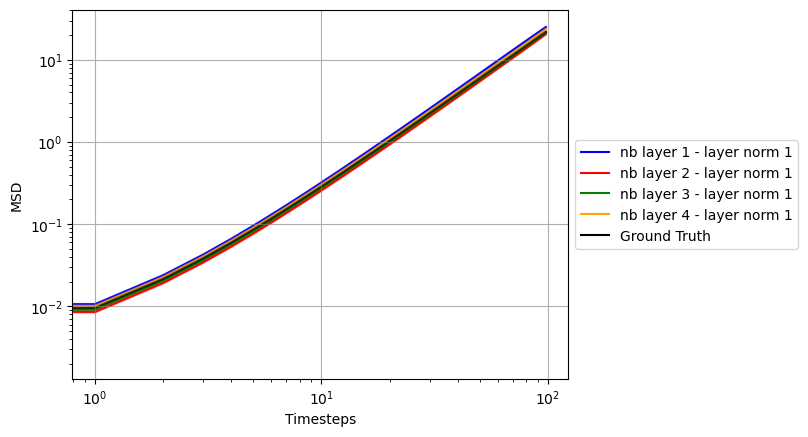

In [46]:
# plot of MSD

res_msd = []


for i in range(len(nb_layer_list)):
    print(MSD_list_noisy[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], linestyle=styles[i], zorder = 1, label = labels_graphs[i])
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_noisy[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.2, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MSD-gat-noisy.png', bbox_inches='tight')
plt.show()


In [47]:
msd_gt = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)

for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {labels_graphs[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: nb layer 1 - layer norm 1 >>>> 2.037562227467049 +- 2.7034636950531383
l1: nb layer 2 - layer norm 1 >>>> 0.4358163403790161 +- 0.472857528780485
l1: nb layer 3 - layer norm 1 >>>> 0.05107656162240173 +- 0.05065262432354761
l1: nb layer 4 - layer norm 1 >>>> 0.4926971461660522 +- 0.7043802091703967


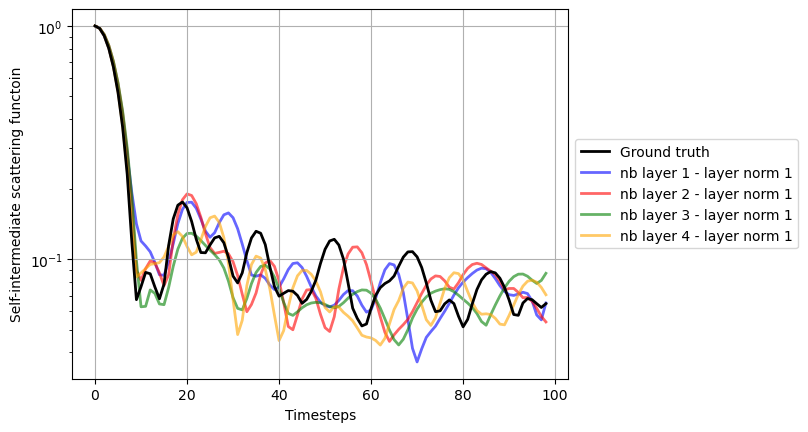

In [48]:
# plot of scat


ssf_mean = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_noisy[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth', zorder = 2)
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(nb_layer_list)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], linestyle=styles[i], lw=2, label = labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-gat-noisy.png', bbox_inches='tight')
plt.show()


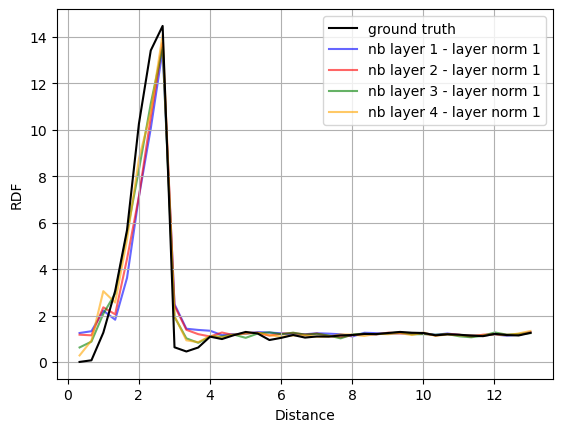

In [49]:
mean_res, std_res, r = RDF_base_noisy
lim_rdf = 40


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4, zorder = 1)

for i in range(len(nb_layer_list)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_noisy[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res,color = colors[i], linestyle=styles[i], label =labels_graphs[i], alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-gat-noisy.png', bbox_inches='tight')
plt.show()

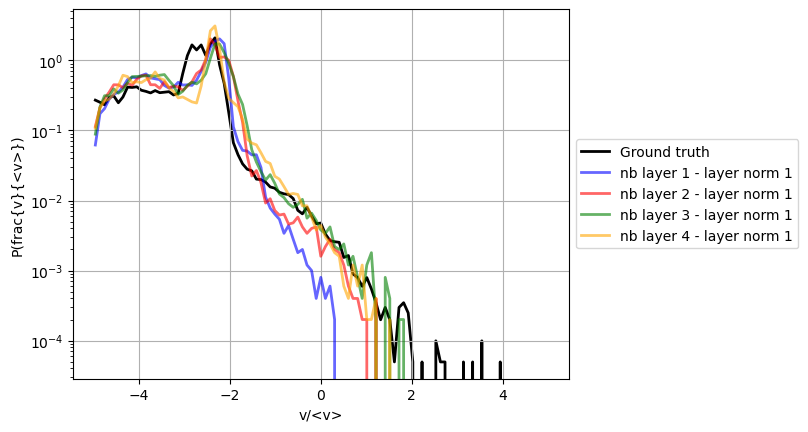

In [50]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-gat-noisy.png', bbox_inches='tight')
plt.show()

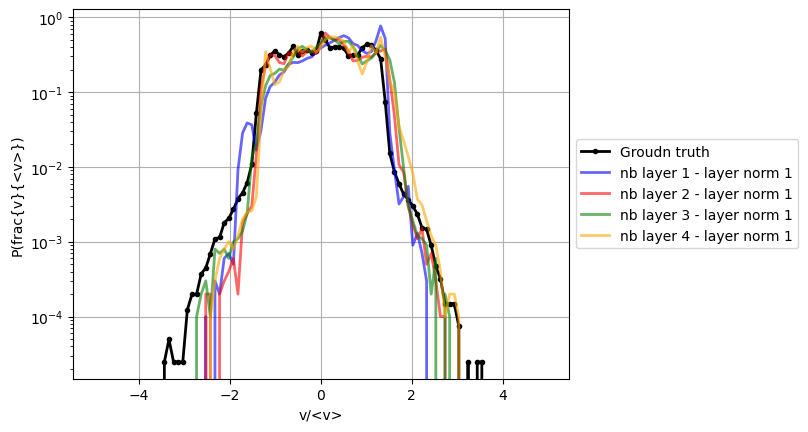

In [51]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig('speed-x-gat-noisy.png', bbox_inches='tight')
plt.show()

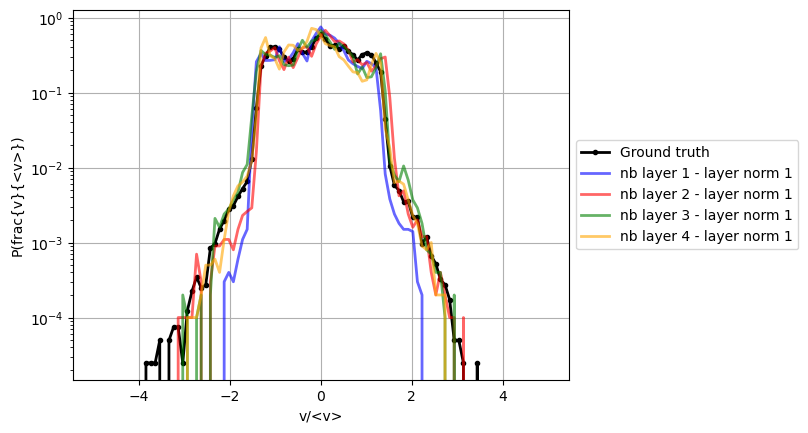

In [52]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(nb_layer_list)):
    magn, x, y = DISTR_list_noisy[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean,color = colors[i], linestyle=styles[i], label =labels_graphs[i], lw=2, zorder = 2, alpha = 0.6)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-gat-noisy.png', bbox_inches='tight')
plt.show()

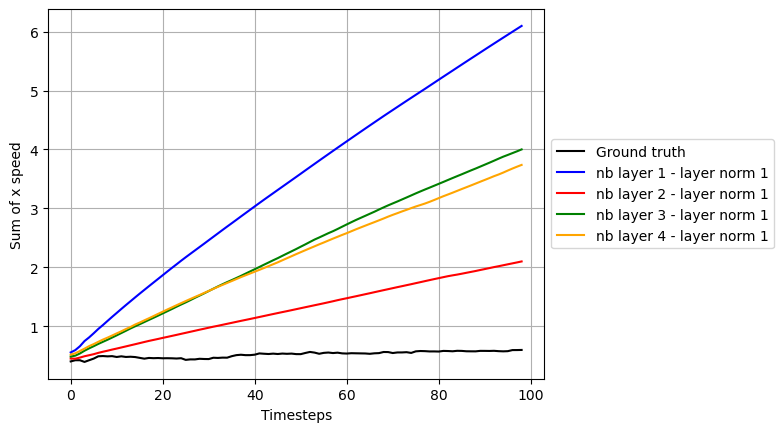

In [53]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-gat-noisy.png', bbox_inches='tight')
plt.show()

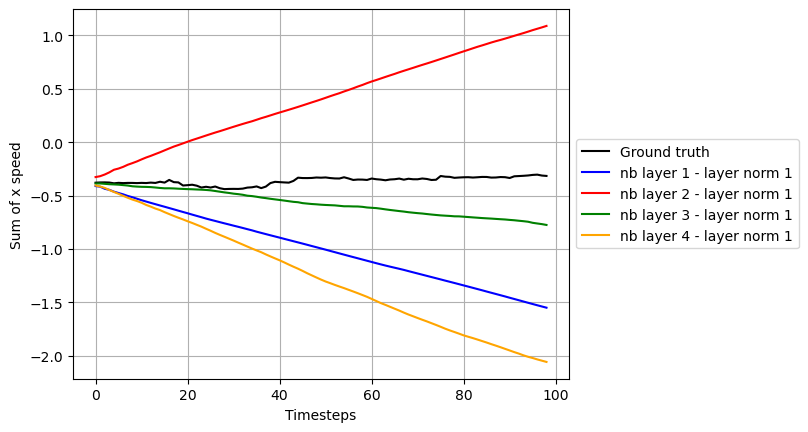

In [54]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(nb_layer_list)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], linestyle=styles[i], label =labels_graphs[i])

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-y-gat-noisy.png', bbox_inches='tight')
plt.show()